# Processamento de arquivos texto para SWAT
Converte arquivos de precipitacao do INMET para entrada do modelo SWAT.

In [2]:
import pandas as pd
%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
import os

In [9]:
# Nome do arquivo de entrada e da coluna com a variavel
INPUT_FILE_NAME = './test/inmet/dados_83076_D_2000-01-01_2020-01-01.csv'    # Nome do arquivo de entrada

DATE_COL = 'Data Medicao'    # Nome da coluna com data
TIME_COL = ''    # Nome da coluna com hora
VARIABLE_COL = 'PRECIPITACAO TOTAL, DIARIO(mm)'    # Nome da coluna com os dados

# Configuracao de formatacao do arquivo de entrada
DELIMITER = ';'    # delimitator entre campos 
SKIP_ROWS = 10    # pula esse numero de linha antes de comercar a ler
ENCODING = 'iso-8859-1'    # Codificacao do arquivo. No Brasil o mais comum eh iso-8859-1. Outro formato comum eh utf-8
DECIMAL = ','    # Caracter utilizado como decimal

# Gera nome do arquivo de saida a partir do de entrada. Geralmente não precisa ser alterado
path, filename = os.path.split(INPUT_FILE_NAME)
newfilename = 'inmet_precip_to_swat_{}'.format(filename)
debugfilename = 'DEBUG_inmet_precip_to_swat_{}'.format(filename)
OUTPUT_FILE_NAME = os.path.join(path, newfilename)    # Nome do arquivo de saida com dados processados para uso no SWAT
DEBUG_FILE_NAME = os.path.join(path, debugfilename)    # Nome do arquivo de saida com dados processados para uso no SWAT
ID = filename    # Codigo identificador da estacao, para ser utilizano no comentario do dado. Serve para confirmar a origem do dado

# Periodo de inicio/fim serie (ano, mes, dia)
SERIE_START_DATE = datetime.date(2000, 1, 1)
SERIE_END_DATE = datetime.date(2016,12,31)
NO_DATA = -99.0

# Passo do modelo
# TODO: ainda nao esta implementado, por enquanto nao é utilizado
STEP = 'day'

# Liga/desliga salvar arquivo de debug (valores com datas). 
# Esse arquivo facilita encontrar possíveis problemas
MAKE_DEBUG_FILE = True

## Le arquivo de entrada e transforma para formato interno

In [10]:
# Abre arquivo com pandas
df = pd.read_csv(INPUT_FILE_NAME, delimiter=DELIMITER, encoding=ENCODING, skiprows=SKIP_ROWS, index_col=False, decimal=DECIMAL)
df

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO(mm)",Unnamed: 2
0,2000-01-01,8.5,NaN
1,2000-01-02,9.6,NaN
2,2000-01-03,15.0,NaN
3,2000-01-04,11.5,NaN
4,2000-01-05,0.0,NaN
...,...,...,...
7301,2019-12-28,0.0,NaN
7302,2019-12-29,0.0,NaN
7303,2019-12-30,2.0,NaN
7304,2019-12-31,0.0,NaN


In [11]:
# Converte coluna de data de texto para formato interno
date = pd.to_datetime(df[DATE_COL], format='%Y-%m-%d')

In [12]:
variable = df[VARIABLE_COL]
variable.index = date
variable = variable.sort_index() # Ordena pelo indice
variable

Data Medicao
2000-01-01     8.5
2000-01-02     9.6
2000-01-03    15.0
2000-01-04    11.5
2000-01-05     0.0
              ... 
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     2.0
2019-12-31     0.0
2020-01-01    20.9
Name: PRECIPITACAO TOTAL, DIARIO(mm), Length: 7306, dtype: float64

## Visualização dos dados parar verificação

Text(0.5, 1.0, 'Day accum')

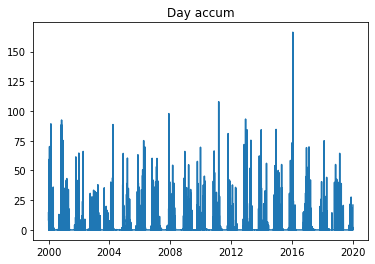

In [13]:
plt.plot(variable)
plt.title('Day accum')

Text(0.5, 1.0, 'Month accum')

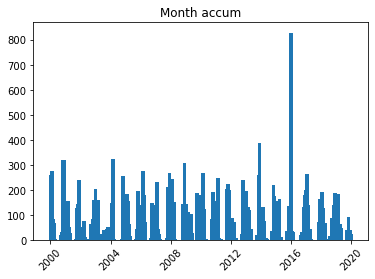

In [14]:
# Acumula mensal para usuario conseguir identificar possíveis falhas 
acc_month = variable.groupby([variable.index.year, variable.index.month]).sum()
index_month = [datetime.date(m[0],m[1], 1) for m in acc_month.index]
plt.bar(index_month, acc_month.values, width=90)
plt.xticks(rotation=45)
plt.title('Month accum')

Text(0.5, 1.0, 'Year accum')

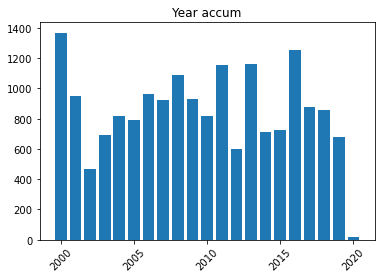

In [15]:
# Acumula anual para usuario conseguir identificar possíveis falhas 
acc_year = variable.groupby(variable.index.year).sum()
plt.bar(acc_year.index, acc_year)
plt.xticks(rotation=45)
plt.title('Year accum')

## Gera arquivo para SWAT
Converte para formato de precipitacao utilizado no SWAT 2012: primeira linha contem o primeiro dia da série em juliano, e os pontos vão sendo adicionados diariamente. Pontos faltando são preenchidos com NO_DATA

In [16]:
# Seleciona faixa de datas
serie = variable[SERIE_START_DATE: SERIE_END_DATE]
serie

Data Medicao
2000-01-01     8.5
2000-01-02     9.6
2000-01-03    15.0
2000-01-04    11.5
2000-01-05     0.0
              ... 
2016-12-27     0.0
2016-12-28     0.0
2016-12-29     0.0
2016-12-30     0.0
2016-12-31     0.0
Name: PRECIPITACAO TOTAL, DIARIO(mm), Length: 6210, dtype: float64

In [17]:
# Preenche falhas na sequencia
# TODO: checar oq ocorre se falta dado no inicio e no fim da serie
# Verificar Nan ou numero invalido
date = SERIE_START_DATE
serie_temp = []
index_temp = []
no_data_count = 0

for index, row in serie.iteritems():
    # completa com NO_DATA se ainda nao tiver index
    # serve para dados anteriores da serie e durante
    while index > date:
        serie_temp.append(NO_DATA)
        index_temp.append(date)
        # incrementa 1 dia
        date += datetime.timedelta(days=1)
        no_data_count += 1
    
    # se for NaN colocar NO_DATA
    if np.isnan(row):
        row = NO_DATA
        no_data_count += 1
        
    # dado existe, vai para a serie
    serie_temp.append(row)
    index_temp.append(date)
    date += datetime.timedelta(days=1)

# Completa a serie caso o tenha acabado os dados observados mas 
# nao chegou ao final da serie
while date <= SERIE_END_DATE:
    serie_temp.append(NO_DATA)
    index_temp.append(date)
    # incrementa 1 dia
    date += datetime.timedelta(days=1)
    no_data_count += 1
    
    
serie_out = pd.Series(serie_temp, index_temp) 
print('Data len: {}'.format(serie_out.size))
print('NO_DATA count: {}'.format(no_data_count))

Data len: 6210
NO_DATA count: 116


In [18]:
# Gera arquivo com valores para calibracao e validacao
with open(OUTPUT_FILE_NAME, 'w') as fo:
    #fo.write('Dados de precipitacao para SWAT 2012\n')
    #fo.write('Arquivo de entrada: {}\n'.format(INPUT_FILE_NAME))
    #fo.write('Arquivo de saida: {}\n'.format(OUTPUT_FILE_NAME))
    #fo.write('Passo: {}\n'.format(STEP))
    
    #fo.write('\n')

    #fo.write('Precipitacao\n')
    #fo.write('Data inicial: {}\n'.format(SERIE_START_DATE))
    #fo.write('Data final: {}\n'.format(SERIE_END_DATE))
    #fo.write('Numero elementos: {}\n'.format(serie_out.size))
    #fo.write('Numero NO_DATA: {}\n'.format(no_data_count))    
    #fo.write('\n')
    
    # Imprime data de inicio no formato AAAAMMDD (ano mes e dia)
    start_date = serie_out.index[0]
    start_date_text =start_date.strftime('%Y%m%d')
    fo.write('{}\n'.format(start_date_text))
    serie_out.to_csv(fo, sep=' ', line_terminator='\n', index=False, header=None)

print('Arquivo de saida: {}'.format(OUTPUT_FILE_NAME))

Arquivo de saida: ./test/inmet/inmet_precip_to_swat_dados_83076_D_2000-01-01_2020-01-01.csv


In [19]:
# Gera arquivo de debug
if MAKE_DEBUG_FILE:
    with open(DEBUG_FILE_NAME, 'w') as fo:
    # Imprime data de inicio no formato AAAAMMDD (ano mes e dia)
        start_date = serie_out.index[0]
        start_date_text =start_date.strftime('%Y%m%d')
        fo.write('{} -- DEBUG: nao utilize no SWAT, somente para verificacao\n'.format(start_date_text))
        serie_out.to_csv(fo, sep=' ', line_terminator='\n', index=True, header=None)

print('Arquivo de DEBUG: {}'.format(DEBUG_FILE_NAME))


Arquivo de DEBUG: ./test/inmet/DEBUG_inmet_precip_to_swat_dados_83076_D_2000-01-01_2020-01-01.csv
